Copyright (c) 2020 Microsoft Corporation. All rights reserved. 

Licensed under the MICROSOFT RESEARCH LICENSE.

# Demo of AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (http://aka.ms/flaml) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast, cheap and scalable. It scales to large datasets and 
has robust performance across different tasks. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to ues FLAML library to run automated ML experiments.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the [notebook] option:
```bash
pip install flaml[notebook]
```

## 2. Real Data Example
### 2.1. Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [1]:
from flaml.util import  load_openml_dataset
X_train, X_test, y_train, y_test =  load_openml_dataset(dataset_id = 1169, data_dir = './')

load dataset from ./openml_ds1169.pkl
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)


### 2.2. Run FLAML with default learners
The default ML learners of FLAML are `[lgbm, xgboost, catboost, rf, extra_tree, lr]`. In the FLAML automl run configuration, users can specify the error metrics, task type, time budget, learner whitelist, sample, cross validation type, and so on.

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 60, # total running time in seconds
    "metric": 'accuracy', # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "estimator_list": ['lgbm', 'rf', 'xgboost'], # white list of ML learners
    "objective_name": 'classification', # task type    
    "sample": False, # whether subsampling training data
    "log_file_name": 'airlines_experiment.log', # cache directory of flaml log files 
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 10-11 23:20:59] {626} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost']
[flaml.automl: 10-11 23:20:59] {631} INFO - Evaluation method: holdout
[flaml.automl: 10-11 23:20:59] {648} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 10-11 23:20:59] {299} INFO - Using StratifiedKFold
[flaml.automl: 10-11 23:20:59] {688} INFO - iteration 0  current learner lgbm
[flaml.automl: 10-11 23:21:01] {755} INFO -  at 2.2s,	best lgbm's error=0.3748	best lgbm's error=0.3748
[flaml.automl: 10-11 23:21:01] {688} INFO - iteration 1  current learner lgbm
[flaml.automl: 10-11 23:21:04] {755} INFO -  at 5.4s,	best lgbm's error=0.3735	best lgbm's error=0.3735
[flaml.automl: 10-11 23:21:04] {688} INFO - iteration 2  current learner xgboost
[flaml.automl: 10-11 23:21:06] {755} INFO -  at 7.9s,	best xgboost's error=0.3742	best lgbm's error=0.3735
[flaml.automl: 10-11 23:21:06] {688} INFO - iteration 3  current learner rf
[flaml.automl: 10-11 23:21:17] {755} INFO -  at 18

### 2.3. Best model and metric

In [5]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.selected.best_config[0])
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_train_time))

Best ML leaner: xgboost
Best hyperparmeter config: {'n_estimators': 23.78576751016593, 'max_leaves': 42.725560437072374, 'min_child_weight': 10.691075276292873, 'learning_rate': 0.08486405325259827, 'subsample': 1.0, 'reg_alpha': 4.942999379112664e-10, 'reg_lambda': 0.6570396759469127, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0}
Best accuracy on validation data: 0.647
Training duration of best run: 5.234 s


In [6]:
automl.model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints=None, learning_rate=0.08486405325259827,
              max_delta_step=0, max_depth=0, max_leaves=43,
              min_child_weight=10.691075276292873, missing=nan,
              monotone_constraints=None, n_estimators=24, n_jobs=-1,
              num_parallel_tree=1, random_state=0,
              reg_alpha=4.942999379112664e-10, reg_lambda=0.6570396759469127,
              scale_pos_weight=1, subsample=1.0, tree_method='hist',
              validate_parameters=False, verbosity=0)

In [7]:
''' pickle and save the best model '''
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(automl.model, f, pickle.HIGHEST_PROTOCOL)

In [8]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels: ', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels:  [1 0 1 ... 1 0 0]
True labels [0 0 0 ... 0 1 0]


In [9]:
''' compute different metric values on testing dataset'''
from flaml.model_compute_helper import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))
print('f1', '=', 1 - sklearn_metric_loss_score('f1', y_pred, y_test))

accuracy = 0.6495854530353143
roc_auc = 0.6942784687592429
log_loss = 0.6276307146709333
f1 = 0.5194451224473192


## 2.4. Log history

In [10]:
from flaml.util import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename = settings['log_file_name'], time_budget = 60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': '364083', 'Current Hyper-parameters': "{'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'reg_alpha': 1e-10, 'reg_lambda': 1.0, 'colsample_bytree': 1.0}", 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'reg_alpha': 1e-10, 'reg_lambda': 1.0, 'colsample_bytree': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': '364083', 'Current Hyper-parameters': "{'n_estimators': 5.4005954671521215, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.130413819159644, 'subsample': 0.6, 'log_max_bin': 3.0, 'reg_alpha': 1.5478543663083856e-10, 'reg_lambda': 1.0, 'colsample_bytree': 1.0}", 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 5.4005954671521215, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.130413819159644, 'subsa

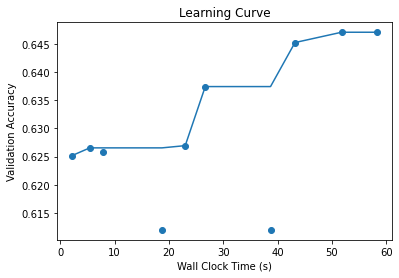

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1- np.array(valid_loss_history))
plt.plot(time_history, 1- np.array(best_valid_loss_history))
plt.show()

## 3. Bring-Your-Own-Model Application

### 3.1. Motivation

Most commercial automl products don't support customized learners provided by users. It is assumed that automl users don't possess prior knowledge of data or ML models. However, some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They have the need to select optimal configurations for the customized model mixed with standard in-house learners. 

However, FLAML can easily incorporate most customized/new learners (preferably with sklearn API) provided by users in a real-time manner. Thus, we here show how to apply the FLAML method to the [*Bring-Your-Own-Model*](https://microsoft-my.sharepoint.com/:w:/g/personal/haoz_microsoft_com1/EW7JfbbBD5FCpw7WMWwjuCMB79pmyzrH3L7x7d5up9XHXw?e=hc2yiJ) (BYOM) application.

### 3.2. Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, there must be some prerequisites for the user. We ask the user to provide or upload the following information:
* an implementation of the customized/new learner (e.g., pickled model, python package, etc)
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

Here in this example, we assume the user has already provided the above information for RGF. We wrap them into a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [12]:
''' BaseEstimator is the parent module for a customized learner '''
from flaml.model_helper import BaseEstimator
from flaml.model_config import ConfigSearchInfo
''' import the original implementation of RGF from rgf.sklearn package'''
from rgf.sklearn import RGFClassifier, RGFRegressor


class MyRegularizedGreedyForest(BaseEstimator):

    
    ''' using sklearn API'''
    def __init__(self, max_leaf = 1000, objective_name = 'binary:logistic', n_jobs = 1, n_iter = 1,  n_tree_search = 1, opt_interval = 1, learning_rate = 1.0, min_samples_leaf = 1):

        '''regression for RGFRegressor; binary:logistic and multiclass for RGFClassifier'''
        self.objective_name = objective_name

        if 'regression' in objective_name:
            self.estimator_class = RGFRegressor
        else:
            self.estimator_class = RGFClassifier

        self.params = {
            'max_leaf': int(round(max_leaf)),
            'n_iter': int(round(n_iter)),
            'n_tree_search': int(round(n_tree_search)),
            'opt_interval': int(round(opt_interval)),
            'learning_rate': learning_rate,
            'min_samples_leaf':int(round(min_samples_leaf))
        }
        
        self.params_configsearch_info = {
            'max_leaf': ConfigSearchInfo(name = 'max_leaf', type = int, lower = 4, init = 4, upper = 10000),
            'n_iter': ConfigSearchInfo(name = 'n_iter', type = int, lower = 1, init = 1, upper = 32768),
            'n_tree_search': ConfigSearchInfo(name = 'n_tree_search', type = int, lower = 1, init = 1, upper = 32768),
            'opt_interval': ConfigSearchInfo(name = 'opt_interval', type = int, lower = 1, init = 100, upper = 10000),
            'learning_rate': ConfigSearchInfo(name = 'learning_rate', type = float, lower = 0.01, init = 1.0, upper = 20.0),
            'min_samples_leaf': ConfigSearchInfo(name = 'min_samples_leaf', type = int, lower = 1, init = 20, upper = 20)
        }

## Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. The automl experiments take the customized learner into account, then output an optimal configuration under the time budget.

In [13]:
''' add a new learner RGF'''
automl = AutoML()
automl.add_learner(learner_name = 'RGF', learner = MyRegularizedGreedyForest)

In [14]:
settings = {
    "time_budget": 60, # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'], # white list of ML learners
    "objective_name": 'classification', # task type    
    "sample": True, # whether subsampling training data
    "log_file_name": 'airlines_experiment.log', # cache directory of flaml log files 
    "log_training_metric": True, # whether to log training metric
}

'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 10-11 23:22:00] {626} INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
[flaml.automl: 10-11 23:22:00] {631} INFO - Evaluation method: holdout
[flaml.automl: 10-11 23:22:00] {648} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 10-11 23:22:01] {299} INFO - Using StratifiedKFold
[flaml.automl: 10-11 23:22:01] {688} INFO - iteration 0  current learner RGF
[flaml.automl: 10-11 23:22:04] {755} INFO -  at 4.1s,	best RGF's error=0.3764	best RGF's error=0.3764
[flaml.automl: 10-11 23:22:04] {688} INFO - iteration 1  current learner RGF
[flaml.automl: 10-11 23:22:09] {755} INFO -  at 9.7s,	best RGF's error=0.3764	best RGF's error=0.3764
[flaml.automl: 10-11 23:22:09] {688} INFO - iteration 2  current learner lgbm
[flaml.automl: 10-11 23:22:09] {755} INFO -  at 9.9s,	best lgbm's error=0.3790	best RGF's error=0.3764
[flaml.automl: 10-11 23:22:09] {688} INFO - iteration 3  current learner lgbm
[flaml.automl: 10-11 23:22:10] {755} INFO -  at 10.3s,